# 9. 폐렴아 기다려라!

## Step 1) 실험환경 Set-up

In [1]:
import re    
import os    
import pandas as pd     
import numpy as np      
import tensorflow as tf  
import matplotlib.pyplot as plt    
from sklearn.model_selection import train_test_split  

In [7]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2) 데이터 준비하기

In [8]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [9]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [10]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1066
Pneumonia images count in training set: 3119


In [11]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [13]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/data/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [14]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다.
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):                 # train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [17]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3) 데이터 시각화

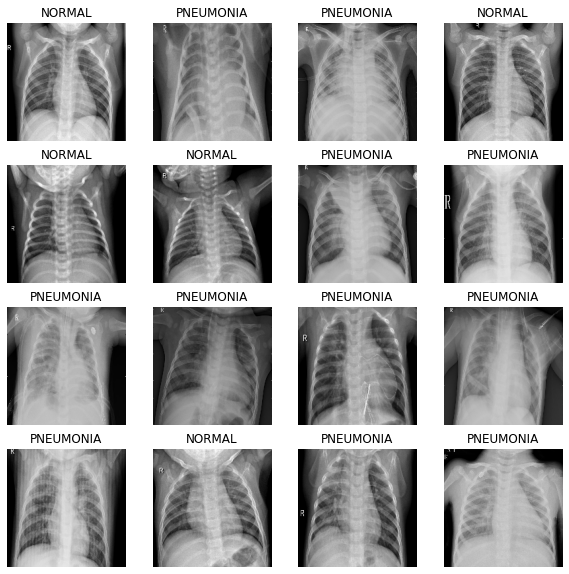

In [19]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4) CNN 모델링

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5) 데이터 imbalance 처리

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.96
Weight for class 1: 0.67


## Step 6) 모델 훈련

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adagrad',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 94s 226ms/step - loss: 0.6489 - accuracy: 0.6442 - precision: 0.8849 - recall: 0.6005 - val_loss: 0.8276 - val_accuracy: 0.2712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.5024 - accuracy: 0.7366 - precision: 0.9413 - recall: 0.6899 - val_loss: 0.5823 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 193ms/step - loss: 0.4472 - accuracy: 0.7718 - precision: 0.9572 - recall: 0.7262 - val_loss: 0.4076 - val_accuracy: 0.7538 - val_precision: 0.7483 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 194ms/step - loss: 0.3793 - accuracy: 0.8039 - precision: 0.9697 - recall: 0.7606 - val_loss: 0.2828 - val_accuracy: 0.9115 - val_precision: 0.9812 - val_recall: 0.8958
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.3644 

## Step 7) 결과 확인과 시각화

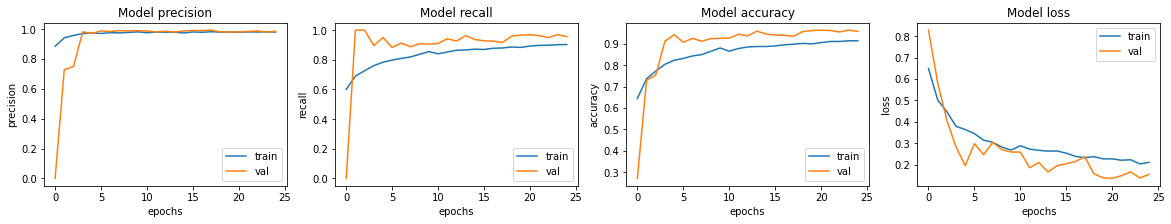

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 4s 108ms/step - loss: 0.3950 - accuracy: 0.8253 - precision: 0.7921 - recall: 0.9769


## step 8)  옵티마이저 변경해보기

In [28]:
with tf.device('/GPU:0'):
    model1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
with tf.device('/GPU:0'):
    history = model1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 189ms/step - loss: 0.3830 - accuracy: 0.8209 - precision: 0.9585 - recall: 0.7940 - val_loss: 0.6638 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2187 - accuracy: 0.9090 - precision: 0.9753 - recall: 0.9007 - val_loss: 1.0697 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1945 - accuracy: 0.9296 - precision: 0.9770 - recall: 0.9273 - val_loss: 0.5480 - val_accuracy: 0.7673 - val_precision: 0.7582 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 190ms/step - loss: 0.1749 - accuracy: 0.9327 - precision: 0.9794 - recall: 0.9294 - val_loss: 0.2107 - val_accuracy: 0.9183 - val_precision: 0.9139 - val_recall: 0.9802
Epoch 5/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1701 - accura

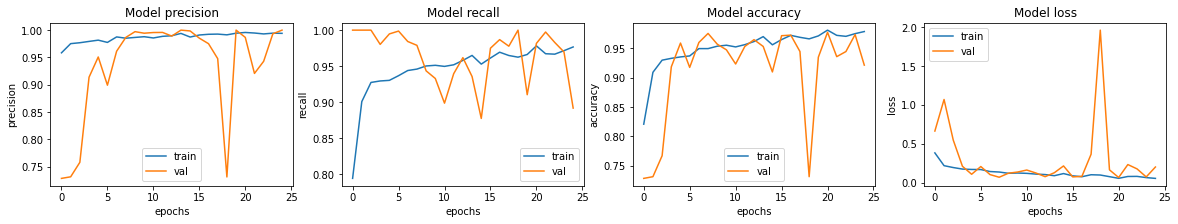

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, acc, prec, rec = model1.evaluate(test_ds)

39/39 [==============================] - 4s 105ms/step - loss: 0.4742 - accuracy: 0.8926 - precision: 0.8892 - recall: 0.9462


## 결과

In [ ]:
변경 할 수 있는 값이 batch size, Epoch 등이 있었다.
하지만 batch size는 32보다 16이 더 정확하고 Epoch은 25가 적당해서 그렇게 했다.

90%를 넘기고 싶었는데 90%를 넘기기가 쉽지 않았다.